*This Notebook is an improved version of AUGs in training for baseline models*

# Parameters

In [1]:
# model's seeds
SEED = 32768

# additional paramters
model_parameter_name = 'sl'
uns_parameter_percentage = 1.0
GPU_ID = '1'

# IMPORTS

In [2]:
import sys
import os

os.environ['CUDA_VISIBLE_DEVICES'] = GPU_ID
sys.path.append(os.path.abspath(".."))       # for 'protonet_mnist_add_utils' folder
sys.path.append(os.path.abspath("../.."))    # for 'data' folder
sys.path.append(os.path.abspath("../../..")) # for 'models' and 'datasets' folders


print(sys.path)

['/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/mnist/notebooks', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python38.zip', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/lib-dynload', '', '/users-1/eleonora/.local/lib/python3.8/site-packages', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/mnist', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation', '/users-1/eleonora/reasoning-shortcuts/IXShort']


In [3]:
import cv2
import torch
import torch.nn as nn
import argparse
import datetime
import importlib
import setproctitle, socket, uuid
import torch.nn.functional as F
import numpy as np
import random

from tqdm import tqdm
from argparse import Namespace
from numpy import float32, zeros
from datasets import get_dataset
from models import get_model
from models.mnistdpl import MnistDPL
from warmup_scheduler import GradualWarmupScheduler
from datasets.utils.base_dataset import BaseDataset
from torchvision import datasets, transforms
from cv2 import (
    INTER_CUBIC, 
    getRotationMatrix2D, 
    imread, 
    warpAffine, 
    moments, 
    WARP_INVERSE_MAP
)
from torch.nn.modules import Module

from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from utils import fprint
from utils.train import train
from utils.test import test
from utils.preprocess_resnet import preprocess
from utils.conf import *
from utils.args import *
from utils.status import progress_bar
from utils.checkpoint import save_model, create_load_ckpt
from utils.dpl_loss import ADDMNIST_DPL
from utils.metrics import (
    evaluate_metrics,
    evaluate_mix,
    mean_entropy,
)
from protonet_mnist_add_modules.utility_modules.proto_utils import ( 
    init_dataloader,
    get_random_classes
)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import cdist

from protonet_mnist_add_modules.arguments import args_sl, args_ltn, args_dpl
from protonet_mnist_add_modules.utility_modules.plotting import plot_training_image
from protonet_mnist_add_modules.data_modules.proto_data_creation import (
    choose_initial_prototypes,
    get_original_support_query_set,
    get_augmented_support_query_set,
    get_augmented_support_query_loader
)
from backbones.addmnist_protonet import PrototypicalLoss

from protonet_mnist_add_modules.utility_modules.setup import my_gpu_info

# SETUP

In [4]:
MODEL = model_parameter_name
UNS_PERCENTAGE = uns_parameter_percentage

print("Model: ", MODEL)
print("Unsupervised Percentage: ", UNS_PERCENTAGE)

Model:  sl
Unsupervised Percentage:  1.0


In [5]:
if MODEL == 'sl':       args = args_sl
elif MODEL == 'ltn':    args = args_ltn
else:                   args = args_dpl

args.seed = SEED
print("Seed: " + str(args.seed))

# logging
args.conf_jobnum = str(uuid.uuid4())
args.conf_timestamp = str(datetime.datetime.now())
args.conf_host = socket.gethostname()

# set job name
setproctitle.setproctitle(
    "{}_{}_{}".format(
        args.model,
        args.buffer_size if "buffer_size" in args else 0,
        args.dataset,
    )
)

# saving
save_folder = "mnadd-even-odd" 
save_model_name = MODEL
save_paths = []
for i in range(len(args.prototypical_loss_weight)):
    save_path = os.path.join("..", "..", 
        "outputs", 
        save_folder, 
        "my_models", 
        save_model_name,
        f"PRE-AUG-baseline"
    )
    save_paths.append(save_path)
print(f"Save paths: {str(save_paths)}")

Seed: 32768
Save paths: ['../../outputs/mnadd-even-odd/my_models/sl/PRE-AUG-baseline']


In [6]:
my_gpu_info()

Torch version:  1.13.0+cu117
CUDA version:  11.7
Number of GPUs available: 1
Device 0: NVIDIA TITAN Xp
  Memory Allocated: 0 bytes
  Memory Cached: 0 bytes


In [7]:
if args.model not in ['mnistsl', 'mnistltn', 'mnistdpl'] or args.prototypes:
    raise ValueError("This experiment is meant for baseline models.")

# Utilities

In [8]:

# * for training data inspection
def plot_training_image(images, labels, plot_index_start=0, plot_index_end=10):
    for plotting_index in range(plot_index_start, plot_index_end + 1):
        image = images[plotting_index].cpu().numpy().transpose(1, 2, 0)
        plt.figure(figsize=(5, 5))
        plt.imshow(image, cmap='gray')
        plt.title(f"Label {labels[plotting_index]}")
        plt.axis('off')
        plt.show()

In [9]:

# * For prototypes computation at test phase 
def get_random_classes(images, labels, n_support):
    unique_classes = torch.unique(labels)
    assert len(unique_classes) == 10, "There should be exactly 10 unique classes."

    selected_images = []
    selected_labels = []

    for cls in unique_classes:
        class_indices = (labels == cls).nonzero(as_tuple=True)[0]
        assert len(class_indices) >= n_support, f"Not enough samples for class {cls}"
        random_indices = torch.randperm(len(class_indices))[:n_support]
        selected_images.append(images[class_indices[random_indices]])
        selected_labels.append(labels[class_indices[random_indices]])

    selected_images = torch.cat(selected_images)
    selected_labels = torch.cat(selected_labels)

    return selected_images, selected_labels

# DATA

## Loading data for training the ProtoNet

In [10]:
args_protonet = Namespace(
    dataset=args.prototypical_dataset,     
    batch_size=args.prototypical_batch_size,
    preprocess=0,
    c_sup=1, # ^ supervision loaded to simulate direct annotation for prototypes
    which_c=[-1],
    model=args.model,        
    task=args.task,    
)

addmnist_dataset = get_dataset(args_protonet)
addmnist_train_loader, _ , _ = addmnist_dataset.get_data_loaders()
print(addmnist_dataset)

Available datasets: ['mnmath', 'xor', 'clipboia', 'shortmnist', 'restrictedmnist', 'minikandinsky', 'presddoia', 'prekandinsky', 'sddoia', 'clipkandinsky', 'addmnist', 'clipshortmnist', 'boia_original', 'boia_original_embedded', 'clipsddoia', 'boia', 'kandinsky', 'halfmnist']
Loading train data
Loading val data
Loading test data


## Create (or get) the initial annotated images-prototype seed and augment it

In [11]:
if ( (not os.path.exists('data/prototypes/proto_loader_dataset.pth')) or args.debug ):
    print("Creating proto_loader_dataset.pth")
    choose_initial_prototypes(addmnist_train_loader, debug=args.debug)

tr_dataloader = init_dataloader()

support_images_aug, support_labels_aug, query_images_aug, query_labels_aug, no_aug = get_augmented_support_query_set(
    tr_dataloader, debug=args.debug)

assert support_images_aug.numel() > 0, "support_images_aug is an empty tensor"
assert support_labels_aug.numel() > 0, "support_labels_aug is an empty tensor"
assert query_images_aug.numel() > 0, "query_images_aug is an empty tensor"
assert query_labels_aug.numel() > 0, "query_labels_aug is an empty tensor"

assert not torch.all(support_images_aug == 0), "All elements in support_images_aug are zero"
assert not torch.all(support_labels_aug == 0), "All elements in support_labels_aug are zero"
assert not torch.all(query_images_aug == 0), "All elements in query_images_aug are zero"
assert not torch.all(query_labels_aug == 0), "All elements in query_labels_aug are zero"

assert no_aug > 0, "no_aug should be greater than 0"

support_loader, query_loader = get_augmented_support_query_loader(
    support_images_aug, 
    support_labels_aug, 
    query_images_aug, 
    query_labels_aug,
    query_batch_size=32,
    debug=args.debug
)

Number of rotations:  400
Number of translations:  1440
Number of scalings:  100
Number of elastic transformations:  250
Number of noising transformations:  40


## Dataset Creation & Check

In [12]:
class MNISTAugDataset(Dataset):
    def __init__(self, images, labels, hide_labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label.squeeze()

    def __len__(self):
        return len(self.labels)

# Example instantiation:
mnist_dataset = MNISTAugDataset(support_images_aug, support_labels_aug)

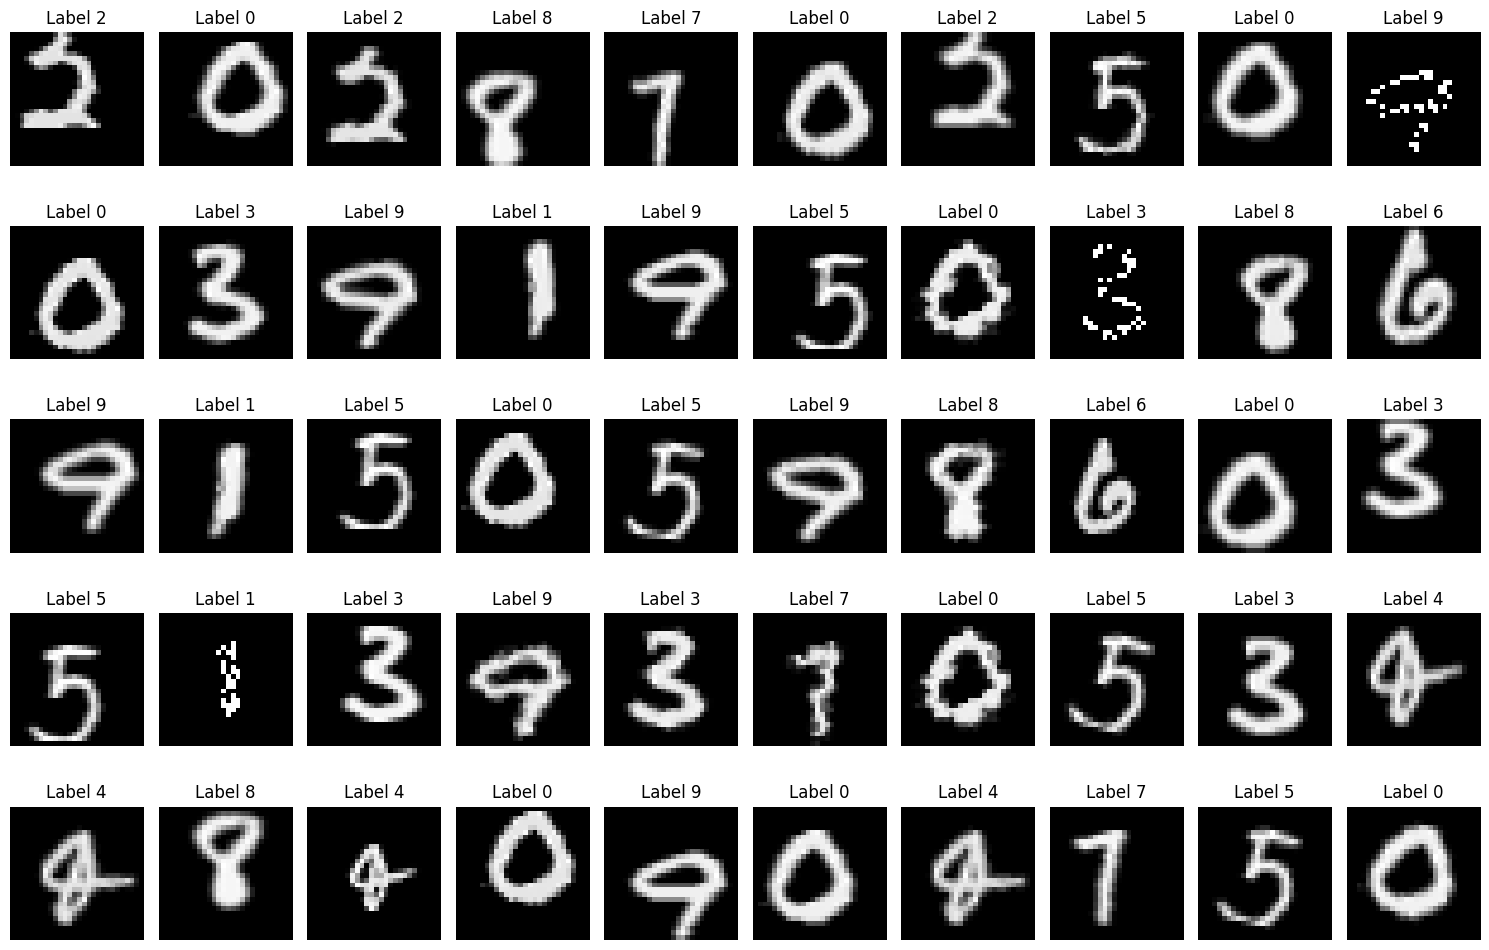

In [13]:
# Plot ten images from the MNISTAugDataset
fig, axes = plt.subplots(5, 10, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    if i < len(mnist_dataset.images):
        offset = random.randint(0, len(mnist_dataset.images) - 1)
        image = mnist_dataset.images[offset].cpu().numpy().transpose(1, 2, 0)
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label {mnist_dataset.labels[offset].item()}")  
        ax.axis('off')
plt.tight_layout()
plt.show()

# plot_training_image(mnist_dataset.images, mnist_dataset.labels, plot_index_start=40, plot_index_end=50)

In [14]:
sup_train_loader = DataLoader(mnist_dataset, batch_size=args.batch_size, shuffle=True)

## Getting the Unsupervised Dataset

In [15]:
dataset = get_dataset(args)
print(dataset)

n_images, c_split = dataset.get_split()
encoder, decoder = dataset.get_backbone()
model = get_model(args, encoder, decoder, n_images, c_split)
loss = model.get_loss(args)
model.start_optim(args)

print("Using Dataset: ", dataset)
print("Using backbone: ", encoder)
print("Using Model: ", model)
print("Using Loss: ", loss)

unsup_train_loader, unsup_val_loader, _ = dataset.get_data_loaders()
dataset.print_stats()

Available datasets: ['mnmath', 'xor', 'clipboia', 'shortmnist', 'restrictedmnist', 'minikandinsky', 'presddoia', 'prekandinsky', 'sddoia', 'clipkandinsky', 'addmnist', 'clipshortmnist', 'boia_original', 'boia_original_embedded', 'clipsddoia', 'boia', 'kandinsky', 'halfmnist']
Available models: ['promnistltn', 'promnmathcbm', 'sddoiann', 'kandnn', 'sddoiadpl', 'sddoialtn', 'kandslsingledisj', 'presddoiadpl', 'boiann', 'mnistclip', 'prokanddpl', 'promnistdpl', 'kandltnsinglejoint', 'xornn', 'mnistnn', 'mnistslrec', 'kandpreprocess', 'kandsl', 'kandsloneembedding', 'prokandltn', 'kandcbm', 'prokandsl', 'boiacbm', 'kanddpl', 'kandltn', 'xorcbm', 'sddoiaclip', 'kanddplsinglejoint', 'xordpl', 'promnmathdpl', 'sddoiacbm', 'mnistltnrec', 'mnmathcbm', 'mnmathdpl', 'kandclip', 'minikanddpl', 'mnistdpl', 'mnistltn', 'boiadpl', 'boialtn', 'kandltnsingledisj', 'prokandsloneembedding', 'mnistpcbmdpl', 'mnistcbm', 'probddoiadpl', 'mnistpcbmsl', 'mnistpcbmltn', 'kanddplsingledisj', 'mnistsl', 'kandsls

Using Dataset:  <datasets.shortcutmnist.SHORTMNIST object at 0x7f5c88ee50a0>
Using backbone:  MNISTSingleEncoder(
  (enc_block_1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_block_2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_block_3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten()
  (dense_logvar): Linear(in_features=1152, out_features=160, bias=True)
  (dense_mu): Linear(in_features=1152, out_features=160, bias=True)
  (dense_c): Linear(in_features=1152, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Using Model:  MnistSL(
  (encoder): MNISTSingleEncoder(
    (enc_block_1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (enc_block_2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (enc_block_3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (flatten): Flatten()
    (dense_logvar): Linear(

## Checkig the Unsupervised Data

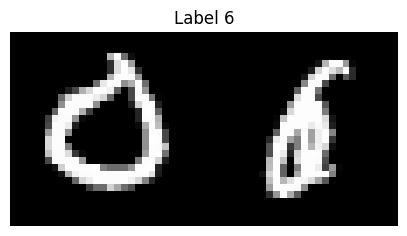

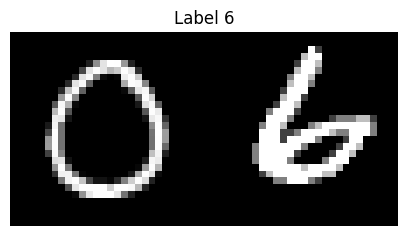

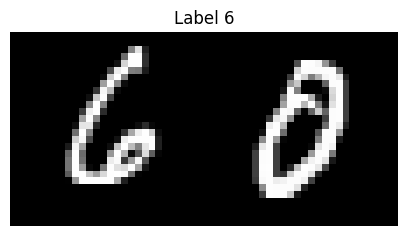

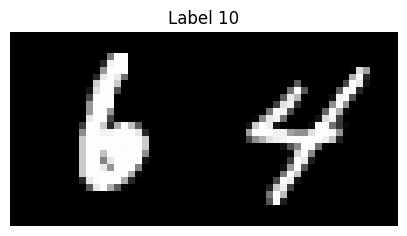

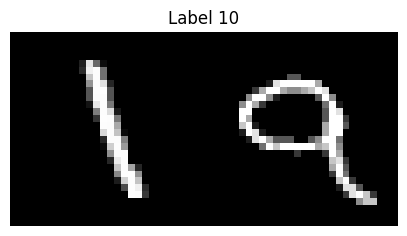

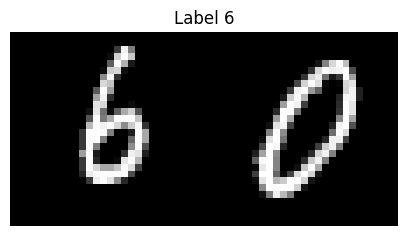

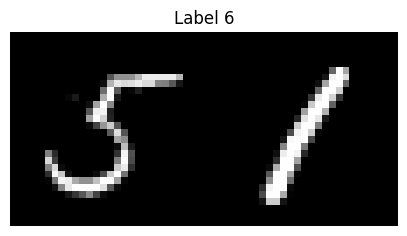

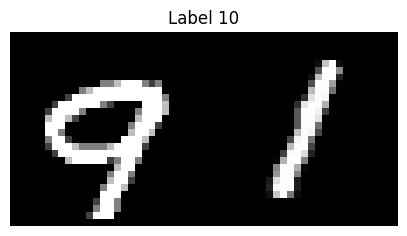

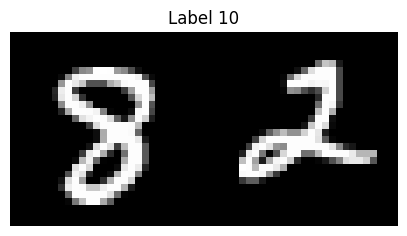

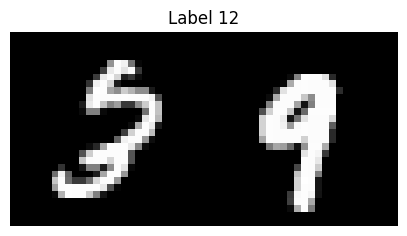

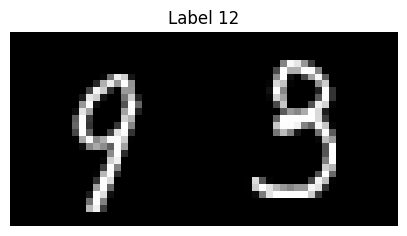

In [16]:
for i, data in enumerate(unsup_train_loader):
    images, labels, concepts = data        
    plot_training_image(images, labels)
    break

# Training

In [17]:
def pre_train(model, train_loader, args, seed: int = 0):
    
    # for full reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = False

    # start optimizer
    enc_opt = torch.optim.Adam(model.encoder.parameters(), args.lr, weight_decay=args.weight_decay)

    fprint("\n--- Start of Training ---\n")
    model.encoder.to(model.device)
    model.encoder.train()

    for epoch in range(args.proto_epochs):
        for i, (images, labels) in enumerate(train_loader):
            sup_images = images.to(model.device)               # shape: (batch_size, C, 28, 28)
            sup_labels = labels.to(model.device)               # shape: (batch_size, 1)
            batch_size = sup_images.size(0)

            assert sup_images.shape == torch.Size([batch_size, 1, 28, 28]), \
            f"Expected shape [{batch_size}, 1, 28, 28], but got {sup_images.shape}"
            assert sup_labels.shape == torch.Size([batch_size, ]), \
            f"Expected shape [{batch_size},], but got {sup_labels.shape}"

            enc_opt.zero_grad()
            preds = model.encoder(sup_images)[0].squeeze(1)
            assert preds.shape == (batch_size, 10), f"Expected preds shape ({batch_size}, 10), but got {preds.shape}"
            
            loss = F.cross_entropy(preds, sup_labels)
            loss.backward()
            enc_opt.step()

            progress_bar(i, len(train_loader), epoch, loss.item())

    # Compute training accuracy
    model.encoder.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(model.device)
            labels = labels.to(model.device)
            preds = model.encoder(images)[0].squeeze(1)
            predicted = torch.argmax(preds, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Training accuracy: {acc:.4f}")

# pre_train(model, sup_train_loader, args)            

## Main Loop

In [18]:
def train(model:MnistDPL,
        sup_train_loader:DataLoader,
        unsup_train_loader:DataLoader,
        unsup_val_loader:DataLoader,
        _loss: ADDMNIST_DPL, 
        args,
        seed,
        save_folder,
    ):
    
    # for full reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = False
    
    best_f1 = 0.0
    epochs_no_improve = 0   # for early stopping

    # model configuration for shortmnist
    if args.dataset == "shortmnist":    model = model.float()
    model.to(model.device)

    # get the data loaders
    scheduler = torch.optim.lr_scheduler.ExponentialLR(model.opt, args.exp_decay)
    w_scheduler = None
    if args.warmup_steps > 0:   w_scheduler = GradualWarmupScheduler(model.opt, 1.0, args.warmup_steps)

    fprint("\n--- Start of Training ---\n")

    # default for warm-up
    model.opt.zero_grad()
    model.opt.step()
    enc_opt = torch.optim.Adam(model.encoder.parameters(), args.lr, weight_decay=args.weight_decay)

    # & FOR EACH EPOCH
    for epoch in range(args.proto_epochs):  
        
        # ^ SUPERVISED TRAINING
        model.encoder.train()
        # & FOR EACH BATCH
        fprint("\n--- Start of Supervised Training ---\n")
        for i, (images, labels) in enumerate(sup_train_loader):
            sup_images = images.to(model.device)               # shape: (batch_size, C, 28, 28)
            sup_labels = labels.to(model.device)               # shape: (batch_size, 1)
            enc_opt.zero_grad()
            preds = model.encoder(sup_images)[0].squeeze(1)
            loss = F.cross_entropy(preds, sup_labels)
            loss.backward()
            enc_opt.step()
            progress_bar(i, len(sup_train_loader), epoch, loss.item())

        model.train()
        # ys are the predictions of the model, y_true are the true labels, cs are the predictions of the concepts, cs_true are the true concepts
        ys, y_true, cs, cs_true = None, None, None, None
        
        # ^ UNSUPERVISED TRAINING
        # & FOR EACH BATCH
        fprint("\n--- Start of Unsupervised Training ---\n")
        for i, data in enumerate(unsup_train_loader):
            if random.random() > UNS_PERCENTAGE:
                continue  # Skip this batch with probability (1 - percentage)

            images, labels, concepts = data
            images, labels, concepts = (
                images.to(model.device),    # input IMAGES
                labels.to(model.device),    # ground truth LABELS
                concepts.to(model.device),  # ground truth CONCEPTS
            )

            # ^ baseline model
            out_dict = model(images)

            ''' Enrich the out_dict with the ground truth labels and concepts '''
            out_dict.update({"LABELS": labels, "CONCEPTS": concepts})

            ''' Extract the predicted concepts for the first image in the batch '''
            model.opt.zero_grad()
            loss, losses = _loss(out_dict, args)
            loss.backward()
            model.opt.step()
            
            if ys is None:  # first iteration
                ys = out_dict["YS"]
                y_true = out_dict["LABELS"]
                cs = out_dict["pCS"]
                cs_true = out_dict["CONCEPTS"]
            else:           # all other iterations
                ys = torch.concatenate((ys, out_dict["YS"]), dim=0)
                y_true = torch.concatenate((y_true, out_dict["LABELS"]), dim=0)
                cs = torch.concatenate((cs, out_dict["pCS"]), dim=0)
                cs_true = torch.concatenate((cs_true, out_dict["CONCEPTS"]), dim=0)

            if i % 10 == 0:
                progress_bar(i, len(unsup_train_loader) - 9, epoch, loss.item())


        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print("End of epoch ", epoch)
        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print()
        
        if UNS_PERCENTAGE == 0.0:
            print("Saving...")
            torch.save(model.state_dict(), save_folder)
            print(f"Saved best model with F1 score: {best_f1}")
            print()
            continue
        
        # enter the evaluation phase
        model.eval()
        # ^ baseline model
        tloss, cacc, yacc, f1 = evaluate_metrics(model, unsup_val_loader, args)

        # update the (warmup) scheduler at end of the epoch
        if epoch < args.warmup_steps:
            w_scheduler.step()
        else:
            scheduler.step()
            if hasattr(_loss, "grade"):
                _loss.update_grade(epoch)

        ### LOGGING ###
        fprint("  ACC C", cacc, "  ACC Y", yacc, "F1 Y", f1)
        print()

        if not args.tuning and f1 > best_f1:
            print("Saving...")
            # Update best F1 score
            best_f1 = f1
            epochs_no_improve = 0

            # Save the best model
            torch.save(model.state_dict(), save_folder)
            print(f"Saved best model with F1 score: {best_f1}")
            print()
        
        elif f1 <= best_f1:
            epochs_no_improve += 1

        if epochs_no_improve >= args.patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    print("End of training")
    return best_f1

## Running

In [19]:
f1_scores = {}
print(f"*** Training model with seed {args.seed}")
print("Chosen device:", model.device)
print("Save path for this model: ", save_path)
if not os.path.exists(save_path): os.makedirs(save_path, exist_ok=True)
save_folder = os.path.join(save_path, f"{save_model_name}_{args.seed}.pth")
print("Saving in folder: ", save_folder)

best_f1 = train(model=model,
    sup_train_loader=sup_train_loader,
    unsup_train_loader=unsup_train_loader,
    unsup_val_loader=unsup_val_loader,
    _loss=loss, 
    args=args,
    seed=args.seed,
    save_folder=save_folder
)
f1_scores[args.seed] = best_f1
save_model(model, args, args.seed)  # save the model parameters

best_weight_seed = max(f1_scores, key=f1_scores.get)
print(f"Best weight and seed combination: {best_weight_seed} with F1 score: {f1_scores[best_weight_seed]}")

*** Training model with seed 32768
Chosen device: cuda
Save path for this model:  ../../outputs/mnadd-even-odd/my_models/sl/PRE-AUG-baseline
Saving in folder:  ../../outputs/mnadd-even-odd/my_models/sl/PRE-AUG-baseline/sl_32768.pth

--- Start of Training ---


--- Start of Supervised Training ---



[ 09-02 | 09:17 ] epoch 0: |██████████████████████████████████████████████████| loss: 1.01966786


--- Start of Unsupervised Training ---



[ 09-02 | 09:17 ] epoch 0: |██████████████████████████████████████████████████| loss: 6.212222581

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 84.73958333333333 F1 Y 84.86667588075234

Saving...
Saved best model with F1 score: 84.86667588075234


--- Start of Supervised Training ---



[ 09-02 | 09:17 ] epoch 1: |██████████████████████████████████████████████████| loss: 0.35894859


--- Start of Unsupervised Training ---



[ 09-02 | 09:17 ] epoch 1: |██████████████████████████████████████████████████| loss: 7.111374861

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 91.875 F1 Y 91.60675741048114

Saving...
Saved best model with F1 score: 91.60675741048114


--- Start of Supervised Training ---



[ 09-02 | 09:17 ] epoch 2: |██████████████████████████████████████████████████| loss: 0.05034002


--- Start of Unsupervised Training ---



[ 09-02 | 09:17 ] epoch 2: |██████████████████████████████████████████████████| loss: 3.204726221

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 93.95833333333333 F1 Y 93.85208187019634

Saving...
Saved best model with F1 score: 93.85208187019634


--- Start of Supervised Training ---



[ 09-02 | 09:17 ] epoch 3: |██████████████████████████████████████████████████| loss: 0.04496579


--- Start of Unsupervised Training ---



[ 09-02 | 09:17 ] epoch 3: |██████████████████████████████████████████████████| loss: 1.58215523

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 97.13541666666667 F1 Y 96.9271133069319

Saving...
Saved best model with F1 score: 96.9271133069319


--- Start of Supervised Training ---



[ 09-02 | 09:17 ] epoch 4: |██████████████████████████████████████████████████| loss: 0.08975477


--- Start of Unsupervised Training ---



[ 09-02 | 09:18 ] epoch 4: |██████████████████████████████████████████████████| loss: 1.46164095

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 97.76041666666667 F1 Y 97.70428185561097

Saving...
Saved best model with F1 score: 97.70428185561097


--- Start of Supervised Training ---



[ 09-02 | 09:18 ] epoch 5: |██████████████████████████████████████████████████| loss: 0.00488295


--- Start of Unsupervised Training ---



[ 09-02 | 09:18 ] epoch 5: |██████████████████████████████████████████████████| loss: 1.60669935

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 98.38541666666667 F1 Y 98.37206389814654

Saving...
Saved best model with F1 score: 98.37206389814654


--- Start of Supervised Training ---



[ 09-02 | 09:18 ] epoch 6: |██████████████████████████████████████████████████| loss: 0.02448285


--- Start of Unsupervised Training ---



[ 09-02 | 09:18 ] epoch 6: |██████████████████████████████████████████████████| loss: 1.10215294

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 98.90625 F1 Y 98.81691730118263

Saving...
Saved best model with F1 score: 98.81691730118263


--- Start of Supervised Training ---



[ 09-02 | 09:18 ] epoch 7: |██████████████████████████████████████████████████| loss: 0.00242768


--- Start of Unsupervised Training ---



[ 09-02 | 09:18 ] epoch 7: |██████████████████████████████████████████████████| loss: 1.06585026

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 98.64583333333333 F1 Y 98.59217427226454


--- Start of Supervised Training ---



[ 09-02 | 09:18 ] epoch 8: |██████████████████████████████████████████████████| loss: 0.00189292


--- Start of Unsupervised Training ---



[ 09-02 | 09:18 ] epoch 8: |██████████████████████████████████████████████████| loss: 3.58766271

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 99.21875 F1 Y 99.17799063714622

Saving...
Saved best model with F1 score: 99.17799063714622


--- Start of Supervised Training ---



[ 09-02 | 09:18 ] epoch 9: |██████████████████████████████████████████████████| loss: 0.00174762


--- Start of Unsupervised Training ---



[ 09-02 | 09:18 ] epoch 9: |██████████████████████████████████████████████████| loss: 0.13036329

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
End of epoch  9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

  ACC C 0.0   ACC Y 98.54166666666667 F1 Y 98.48357219491957

End of training
Best weight and seed combination: 32768 with F1 score: 99.17799063714622
